<a href="https://colab.research.google.com/github/Leonardo-Lopes-Borem-Peixoto/House-price-prediction/blob/main/Desafio_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Loading the dataset
data = pd.read_json('dataset_bruto.json')
# Selecting only the column with the information of interest, which contains the property information.
data_advertisement = pd.json_normalize(data['anuncio'])
# For the purpose of this analysis, only apartment properties that have been sold for residential use are to be considered. So the dataset needs to be filtered to only
# include these properties.
df_adv = data_advertisement.query('tipo_anuncio == "Usado" and tipo_unidade == "Apartamento" and tipo_uso == "Residencial"').reset_index(drop=True)
# The column "valores" contains lists with dictionaries. The elements of those dictionaries need to be separated in individual columns
val = pd.json_normalize(pd.json_normalize(df_adv['valores'])[0])
df_adv = pd.concat([df_adv,val],axis=1)
df_adv.drop('valores',axis=1,inplace=True)
df_adv


,id,caracteristicas,area_util,tipo_anuncio,tipo_unidade,andar,vaga,suites,banheiros,tipo_uso,...,endereco.longitude,endereco.latitude,endereco.zona,endereco.rua,endereco.estado,endereco.bairro,iptu,condominio,valor,tipo
0,d2e3a3aa-09b5-45a0-9dcd-918847cd3ca3,"[Academia, Churrasqueira, Playground, Salão de...",[43],Usado,Apartamento,3,[1],[],[1],Residencial,...,-43.634034,-22.919851,Zona Oeste,Estrada de Santa Eugênia,Rio de Janeiro,Paciência,None,245,15000,Venda
1,085bab2c-87ad-452a-bd0f-8b1451509f84,"[Churrasqueira, Playground, Salão de festas, C...",[42],Usado,Apartamento,2,[1],[],[1],Residencial,...,-43.635375,-22.928108,Zona Oeste,Estrada de Santa Eugênia,Rio de Janeiro,Paciência,0,0,15000,Venda
2,18d22cbe-1b86-4764-8def-70c615f15a61,"[Portaria 24h, Condomínio fechado, Playground,...",[41],Usado,Apartamento,1,[1],[],[1],Residencial,...,-43.582824,-22.948756,Zona Oeste,Estrada Cabuçu de Baixo,Rio de Janeiro,Guaratiba,0,0,20000,Venda
3,bed8a354-9317-4426-b27e-1c798f864271,"[Churrasqueira, Piscina, Playground, Salão de ...",[43],Usado,Apartamento,3,[0],[],[1],Residencial,...,-43.629602,-22.888194,Zona Oeste,Estrada da Paciência,Rio de Janeiro,Cosmos,None,285,20000,Venda
4,12a13315-d67f-48f0-9497-017b83252781,"[Academia, Churrasqueira, Playground, Salão de...",[43],Usado,Apartamento,2,[1],[],[1],Residencial,...,-43.582205,-22.948291,Zona Oeste,Estrada Cabuçu de Baixo,Rio de Janeiro,Guaratiba,None,245,15000,Venda
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66557,5831f3d1-e004-414e-b717-2f346a440295,"[Academia, Churrasqueira, Piscina, Salão de fe...",[648],Usado,Apartamento,20,[4],[5],[6],Residencial,...,-43.372285,-23.000105,Zona Oeste,Avenida das Américas,Rio de Janeiro,Barra da Tijuca,44629,9654,13785527,Venda
66558,8577a5cf-b6c7-4b67-9f51-9dce456a493a,"[Academia, Churrasqueira, Piscina, Playground,...",[648],Usado,Apartamento,20,[5],[5],[6],Residencial,...,-43.403944,-23.002119,Zona Oeste,Avenida das Américas,Rio de Janeiro,Barra da Tijuca,44629,8385,13785527,Venda
66559,db22bde4-838a-4ff1-8e85-cac62fd159f9,"[Academia, Condomínio fechado, Elevador, Pisci...",[648],Usado,Apartamento,20,[5],[5],[7],Residencial,...,-43.403574,-23.001314,Zona Oeste,Avenida das Américas,Rio de Janeiro,Barra da Tijuca,39570,10200,13785527,Venda
66560,382599ac-7751-4ade-8a57-bb9633579a46,"[Condomínio fechado, Portão eletrônico, Portar...",[264],Usado,Apartamento,1,[3],[1],[2],Residencial,...,-43.201120,-22.986417,Zona Sul,Avenida Vieira Souto,Rio de Janeiro,Ipanema,3200,3970,13900000,Venda


In [3]:
# Filtering by sold apartments only
df_adv = df_adv.query('tipo=="Venda"').reset_index(drop=True)
# Getting the special features lists on the column "caracteristicas" for posterior one hot encoding
characteristics = set(cat for sublist in df_adv['caracteristicas'] for cat in sublist)
# One hot encoding the column 'caracteristicas'
for special_feature in characteristics:
  df_adv[special_feature] = df_adv['caracteristicas'].apply(lambda x: 1 if special_feature in x else 0)
df_adv.drop('caracteristicas',inplace=True,axis=1)
# Converting the columns to their proper Dtype
convert_col = ['area_util','vaga','suites','banheiros','area_total','quartos','iptu','condominio','valor']
for col in convert_col:
  df_2 = pd.DataFrame(df_adv[col].to_list(),index=df_adv.index)
  df_adv = pd.concat([df_adv,df_2],axis=1)
  df_adv.drop(col,axis=1,inplace=True)
  df_adv.rename(columns={0:col},inplace=True)
  df_adv[col] = df_adv[col].apply(pd.to_numeric,errors='coerce')
#removing Nan
df_adv.fillna(value=0,inplace=True)
# Removing the columns with irrelevant information
df_adv.drop(['endereco.pais','endereco.cep','endereco.cidade','endereco.longitude','endereco.latitude','endereco.estado',
             'tipo_anuncio','tipo_unidade','tipo_uso','tipo','area_util','endereco.zona'],inplace=True,axis=1)
df_adv.rename(columns={'endereco.bairro':'bairro','endereco.rua':'rua'},inplace=True)
# Setting the index
df_adv.set_index('id',inplace=True)
df_adv

,andar,rua,bairro,Piscina,Portaria 24h,Playground,Animais permitidos,Condomínio fechado,Portão eletrônico,Churrasqueira,...,Salão de festas,Elevador,vaga,suites,banheiros,area_total,quartos,iptu,condominio,valor
id,,,,,,,,,,,,,,,,,,,,,
d2e3a3aa-09b5-45a0-9dcd-918847cd3ca3,3,Estrada de Santa Eugênia,Paciência,0,1,1,1,1,1,1,...,1,0,1.0,0.0,1,43.0,2,0.0,245.0,15000
085bab2c-87ad-452a-bd0f-8b1451509f84,2,Estrada de Santa Eugênia,Paciência,0,1,1,1,1,1,1,...,1,0,1.0,0.0,1,42.0,2,0.0,0.0,15000
18d22cbe-1b86-4764-8def-70c615f15a61,1,Estrada Cabuçu de Baixo,Guaratiba,0,1,1,0,1,1,1,...,1,0,1.0,0.0,1,41.0,2,0.0,0.0,20000
bed8a354-9317-4426-b27e-1c798f864271,3,Estrada da Paciência,Cosmos,1,1,1,1,1,1,1,...,1,0,0.0,0.0,1,43.0,2,0.0,285.0,20000
12a13315-d67f-48f0-9497-017b83252781,2,Estrada Cabuçu de Baixo,Guaratiba,0,1,1,1,1,1,1,...,1,0,1.0,0.0,1,43.0,2,0.0,245.0,15000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5831f3d1-e004-414e-b717-2f346a440295,20,Avenida das Américas,Barra da Tijuca,1,1,1,1,1,1,1,...,1,1,4.0,5.0,6,648.0,5,44629.0,9654.0,13785527
8577a5cf-b6c7-4b67-9f51-9dce456a493a,20,Avenida das Américas,Barra da Tijuca,1,1,1,0,1,1,1,...,1,1,5.0,5.0,6,0.0,5,44629.0,8385.0,13785527
db22bde4-838a-4ff1-8e85-cac62fd159f9,20,Avenida das Américas,Barra da Tijuca,1,1,1,0,1,1,0,...,1,1,5.0,5.0,7,648.0,5,39570.0,10200.0,13785527


In [4]:
df_adv.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66348 entries, d2e3a3aa-09b5-45a0-9dcd-918847cd3ca3 to c823e3c7-02c7-459d-bb8a-a04847a0a839
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   andar               66348 non-null  int64  
 1   rua                 66348 non-null  object 
 2   bairro              66348 non-null  object 
 3   Piscina             66348 non-null  int64  
 4   Portaria 24h        66348 non-null  int64  
 5   Playground          66348 non-null  int64  
 6   Animais permitidos  66348 non-null  int64  
 7   Condomínio fechado  66348 non-null  int64  
 8   Portão eletrônico   66348 non-null  int64  
 9   Churrasqueira       66348 non-null  int64  
 10  Academia            66348 non-null  int64  
 11  Salão de festas     66348 non-null  int64  
 12  Elevador            66348 non-null  int64  
 13  vaga                66348 non-null  float64
 14  suites              66348 non-null  float

In [5]:
# Target encoding the variable "bairro", which represents the neighborhood of the property. This variable has high cardinality and one hot enconding is not adviseble.
# Computing the global mean
mean = df_adv['valor'].mean()
# Compute the number of values and the mean of each group
agg = df_adv.groupby('bairro')['valor'].agg(['count', 'mean'])
agg2 = df_adv.groupby('rua')['valor'].agg(['count','mean'])
counts = agg['count']
means = agg['mean']
counts_rua = agg2['count']
means_rua = agg2['mean']
# Compute the "smoothed" means
smooth = (counts * means + 10 * mean) / (counts + 10)
smooth2 = (counts_rua*means_rua + 3*mean)/(counts_rua + 3)
# Replace each value by the according smoothed mean
df_adv['bairro'] = df_adv['bairro'].map(smooth)
df_adv['rua'] = df_adv['rua'].map(smooth2)
df_adv

,andar,rua,bairro,Piscina,Portaria 24h,Playground,Animais permitidos,Condomínio fechado,Portão eletrônico,Churrasqueira,...,Salão de festas,Elevador,vaga,suites,banheiros,area_total,quartos,iptu,condominio,valor
id,,,,,,,,,,,,,,,,,,,,,
d2e3a3aa-09b5-45a0-9dcd-918847cd3ca3,3,3.607681e+05,7.109753e+05,0,1,1,1,1,1,1,...,1,0,1.0,0.0,1,43.0,2,0.0,245.0,15000
085bab2c-87ad-452a-bd0f-8b1451509f84,2,3.607681e+05,7.109753e+05,0,1,1,1,1,1,1,...,1,0,1.0,0.0,1,42.0,2,0.0,0.0,15000
18d22cbe-1b86-4764-8def-70c615f15a61,1,3.715543e+05,3.573412e+05,0,1,1,0,1,1,1,...,1,0,1.0,0.0,1,41.0,2,0.0,0.0,20000
bed8a354-9317-4426-b27e-1c798f864271,3,3.883489e+05,3.342901e+05,1,1,1,1,1,1,1,...,1,0,0.0,0.0,1,43.0,2,0.0,285.0,20000
12a13315-d67f-48f0-9497-017b83252781,2,3.715543e+05,3.573412e+05,0,1,1,1,1,1,1,...,1,0,1.0,0.0,1,43.0,2,0.0,245.0,15000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5831f3d1-e004-414e-b717-2f346a440295,20,2.959546e+06,2.229228e+06,1,1,1,1,1,1,1,...,1,1,4.0,5.0,6,648.0,5,44629.0,9654.0,13785527
8577a5cf-b6c7-4b67-9f51-9dce456a493a,20,2.959546e+06,2.229228e+06,1,1,1,0,1,1,1,...,1,1,5.0,5.0,6,0.0,5,44629.0,8385.0,13785527
db22bde4-838a-4ff1-8e85-cac62fd159f9,20,2.959546e+06,2.229228e+06,1,1,1,0,1,1,0,...,1,1,5.0,5.0,7,648.0,5,39570.0,10200.0,13785527


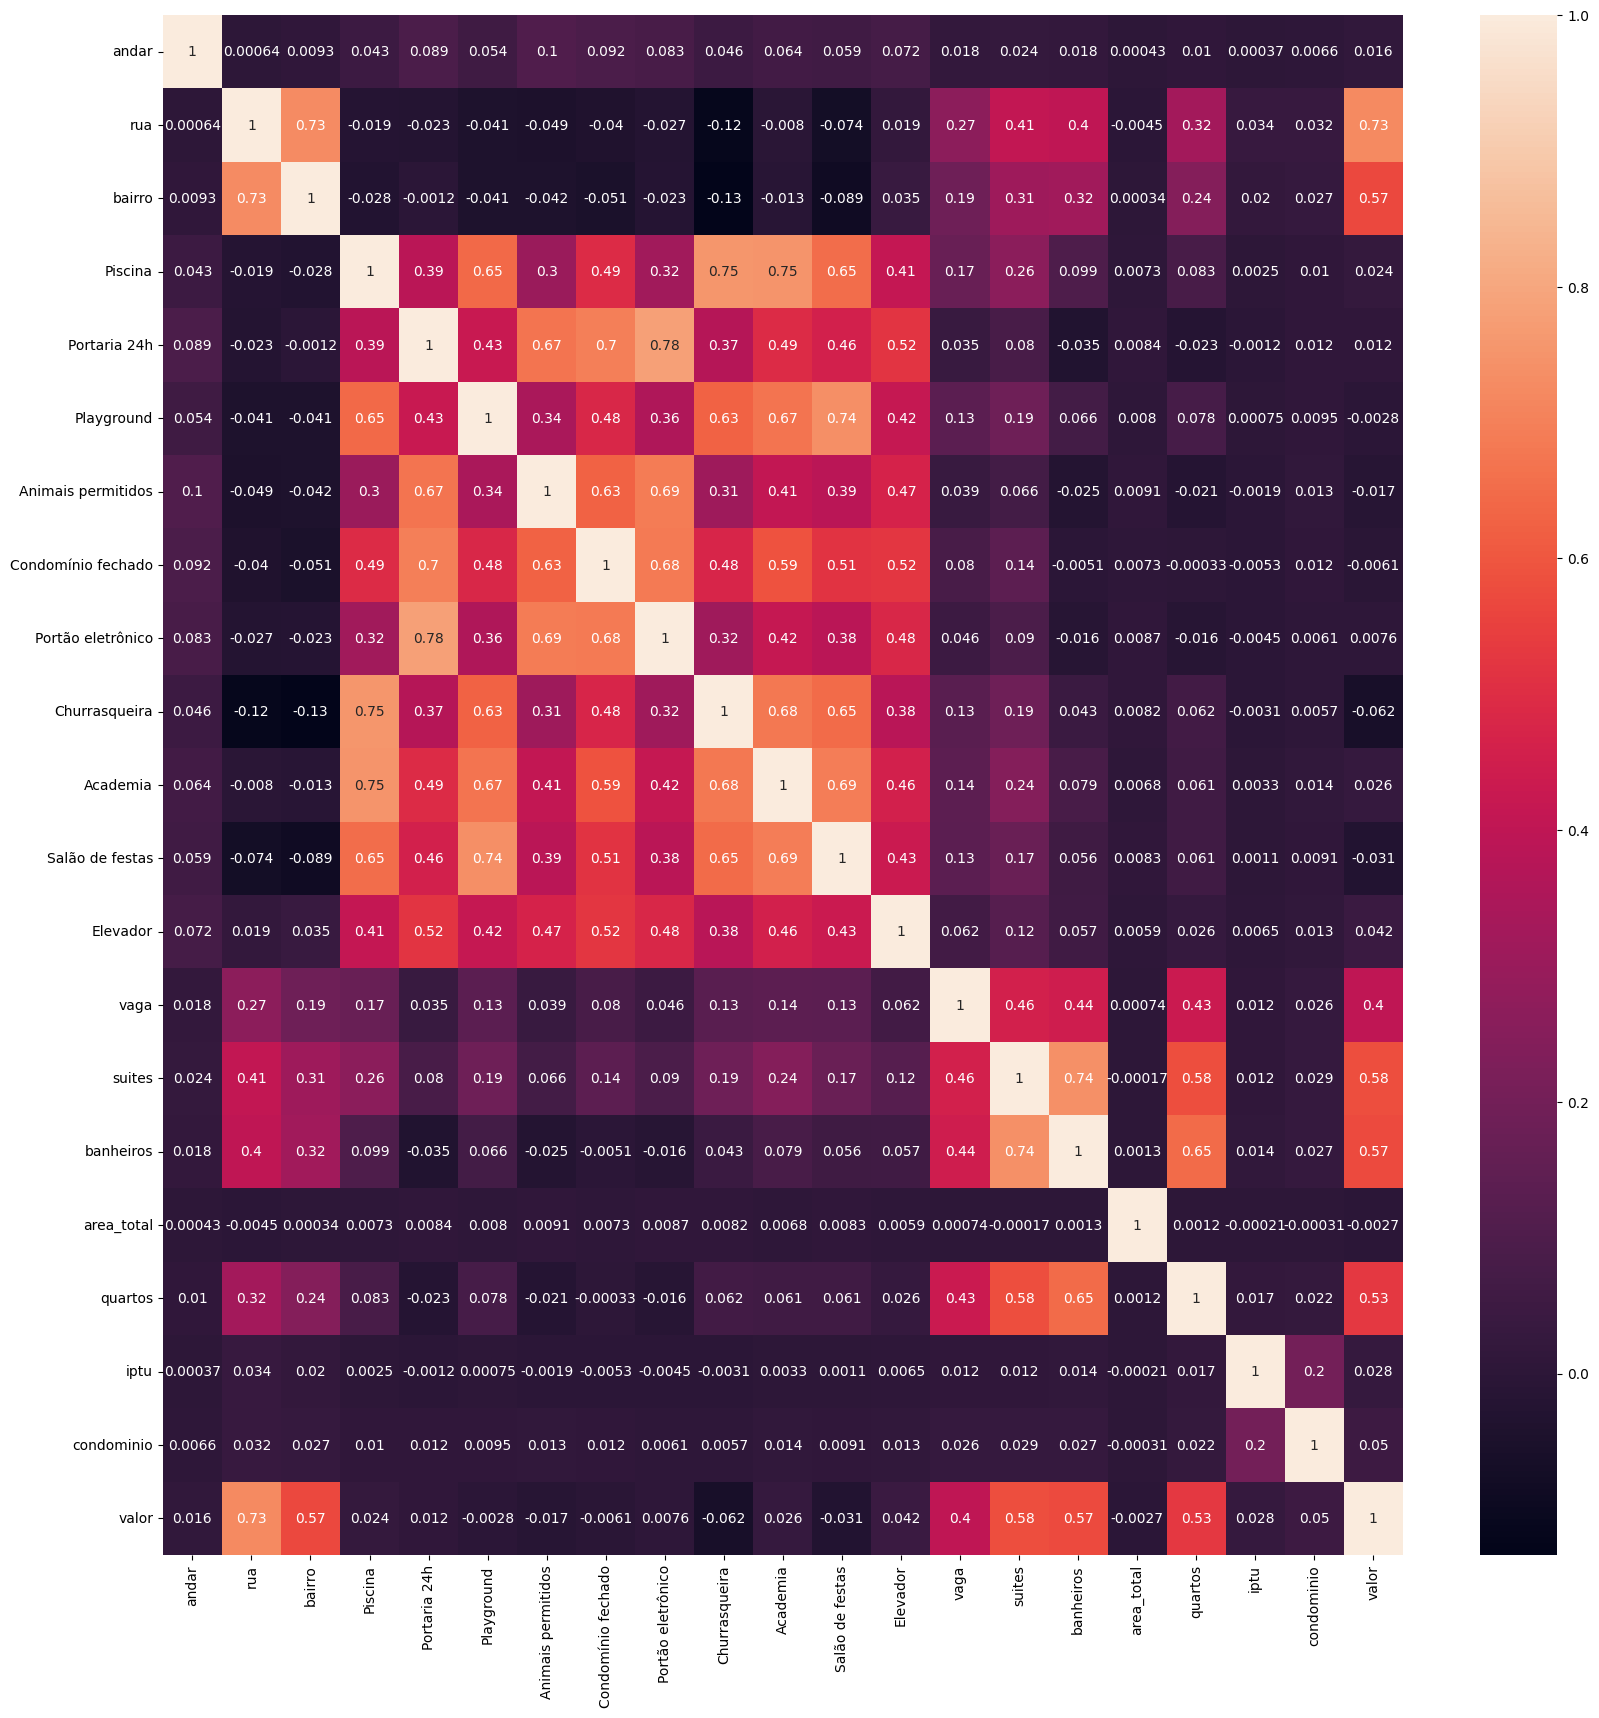

In [6]:
# Testing the correlation between features and the target variable
fig,ax = plt.subplots(figsize=(20,20))
ax = sns.heatmap(df_adv.corr(), annot = True)

In [7]:
# Dropping the features that have low correlation with the property price
df_adv.drop(['andar','Animais permitidos','Playground','Piscina','Salão de festas','Academia','Condomínio fechado','Portaria 24h','Portão eletrônico',
'Elevador','area_total','iptu','condominio','Churrasqueira'],inplace=True,axis=1)
# Scaling the features with large range of values
scaler = MinMaxScaler()
features_S = scaler.fit_transform(df_adv[['bairro','rua']])
df_adv[['bairro','rua']] = features_S
df_adv

,rua,bairro,vaga,suites,banheiros,quartos,valor
id,,,,,,,
d2e3a3aa-09b5-45a0-9dcd-918847cd3ca3,0.019881,0.154581,1.0,0.0,1,2,15000
085bab2c-87ad-452a-bd0f-8b1451509f84,0.019881,0.154581,1.0,0.0,1,2,15000
18d22cbe-1b86-4764-8def-70c615f15a61,0.021435,0.039150,1.0,0.0,1,2,20000
bed8a354-9317-4426-b27e-1c798f864271,0.023853,0.031626,0.0,0.0,1,2,20000
12a13315-d67f-48f0-9497-017b83252781,0.021435,0.039150,1.0,0.0,1,2,15000
...,...,...,...,...,...,...,...
5831f3d1-e004-414e-b717-2f346a440295,0.394113,0.650160,4.0,5.0,6,5,13785527
8577a5cf-b6c7-4b67-9f51-9dce456a493a,0.394113,0.650160,5.0,5.0,6,5,13785527
db22bde4-838a-4ff1-8e85-cac62fd159f9,0.394113,0.650160,5.0,5.0,7,5,13785527


In [8]:
# Splitting in trainning, cross-validation and test sets
features_df = df_adv.drop(['valor'],axis=1)
target_df = df_adv['valor']
x_train,x2,y_train,y2 = train_test_split(features_df,target_df,test_size=0.4)
x_test,x_cv,y_test,y_cv = train_test_split(x2,y2,test_size=0.5)


In [9]:
# Converting to numpy arrays
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_cv = x_cv.to_numpy()
y_train =  y_train.to_numpy()
y_test =  y_test.to_numpy()
y_cv =  y_cv.to_numpy()

In [13]:
# Building and training the neural network
callback = [tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',factor=0.5,patience=5,min_lr=1e-12),tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',restore_best_weights=True,patience=10)]
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=200,activation='relu'),
    tf.keras.layers.Dense(units=100,activation='relu'),
    tf.keras.layers.Dense(units=50,activation='relu'),
    tf.keras.layers.Dense(units=25,activation='relu'),
    tf.keras.layers.Dense(units=12,activation='relu'),
    tf.keras.layers.Dense(units=6,activation='relu'),
    tf.keras.layers.Dense(units=1,activation='linear')
])
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])
history = model.fit(x_train,y_train,epochs=200,validation_data=(x_cv,y_cv),callbacks=[callback])

Epoch 1/200
1244/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 2172451946496.0000 - mean_absolute_percentage_error: 93.1702 - val_loss: 1019490533376.0000 - val_mean_absolute_percentage_error: 64.5507 - learning_rate: 0.0010
Epoch 2/200
1244/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 876491112448.0000 - mean_absolute_percentage_error: 54.5132 - val_loss: 744483782656.0000 - val_mean_absolute_percentage_error: 39.9416 - learning_rate: 0.0010
Epoch 3/200
1244/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 723646939136.0000 - mean_absolute_percentage_error: 39.2224 - val_loss: 662708224000.0000 - val_mean_absolute_percentage_error: 43.8306 - learning_rate: 0.0010
Epoch 4/200
1244/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 626059706368.0000 - mean_absolute_percentage_error: 40.9458 - val_loss: 605352230912.0000 - val_mean_absolute_percentage_error: 42.7076 - learning_rate: 0.0010
Epoch 5/200
1244/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 600942968832.0000 - mean_absolute_percenta

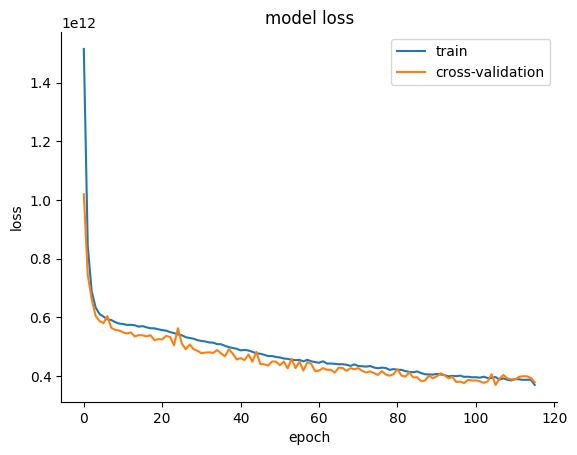

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'cross-validation'], loc='upper right')
ax = plt.gca()
ax.spines[['right', 'top']].set_visible(False)
plt.show()

In [15]:
model.evaluate(x_test,y_test)

415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 363764285440.0000 - mean_absolute_percentage_error: 27.0598


[413350035456.0, 27.626033782958984]

In [16]:
pred = model.predict(x_test)
predictions = pred/1000000

415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [17]:
Reality = y_test/1000000

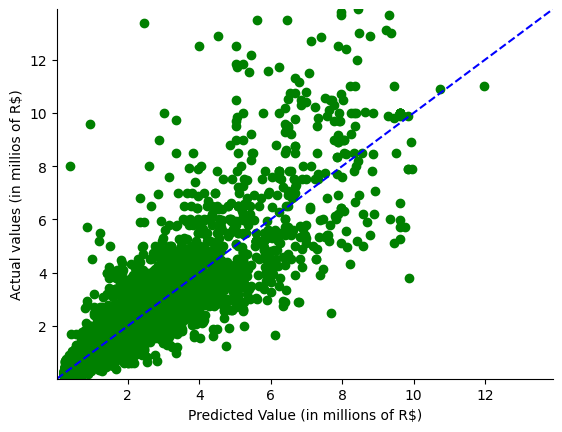

In [18]:
plt.figure()
plt.plot(predictions,Reality,'go')
y_min = min(min(Reality), min(predictions))
y_max = max(max(Reality), max(predictions))
plt.xlim([y_min, y_max])
plt.ylim([y_min, y_max])
plt.plot([y_min, y_max], [y_min, y_max], 'b--')
ax = plt.gca()
plt.xlabel('Predicted Value (in millions of R$)')
plt.ylabel('Actual values (in millios of R$)')
ax.spines[['top','right']].set_visible(False)
plt.show()